# Customer Churn Prediction for Credit Card Dataset

**Objective:** Predict which customers might stop using their credit cards or switch to a competitor.

This notebook implements:
1. Exploratory Data Analysis (EDA)
2. Data preprocessing and feature engineering  
3. Synthetic target variable creation for churn prediction
4. Machine learning model training and evaluation
5. Feature importance analysis


In [2]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Load Data and Initial EDA


In [3]:
# Load the credit card dataset
credit_card = pd.read_csv('data/CC GENERAL.csv')

def EDA_data(df):
    print("Basic Information:\n")
    print(df.info())
    print("\nShape of the dataset:\n", df.shape)
    print("\nData types:\n", df.dtypes)
    print("\nSummary of the dataset:\n", df.describe())
    print("\nFirst 5 rows:\n", df.head())
    print("\nLast 5 rows:\n", df.tail())

def missing_values(df):
    print("\nMissing values:\n", df.isnull().sum())

EDA_data(credit_card)
missing_values(credit_card)

Basic Information:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null  

# Data Visualization and Outlier Analysis

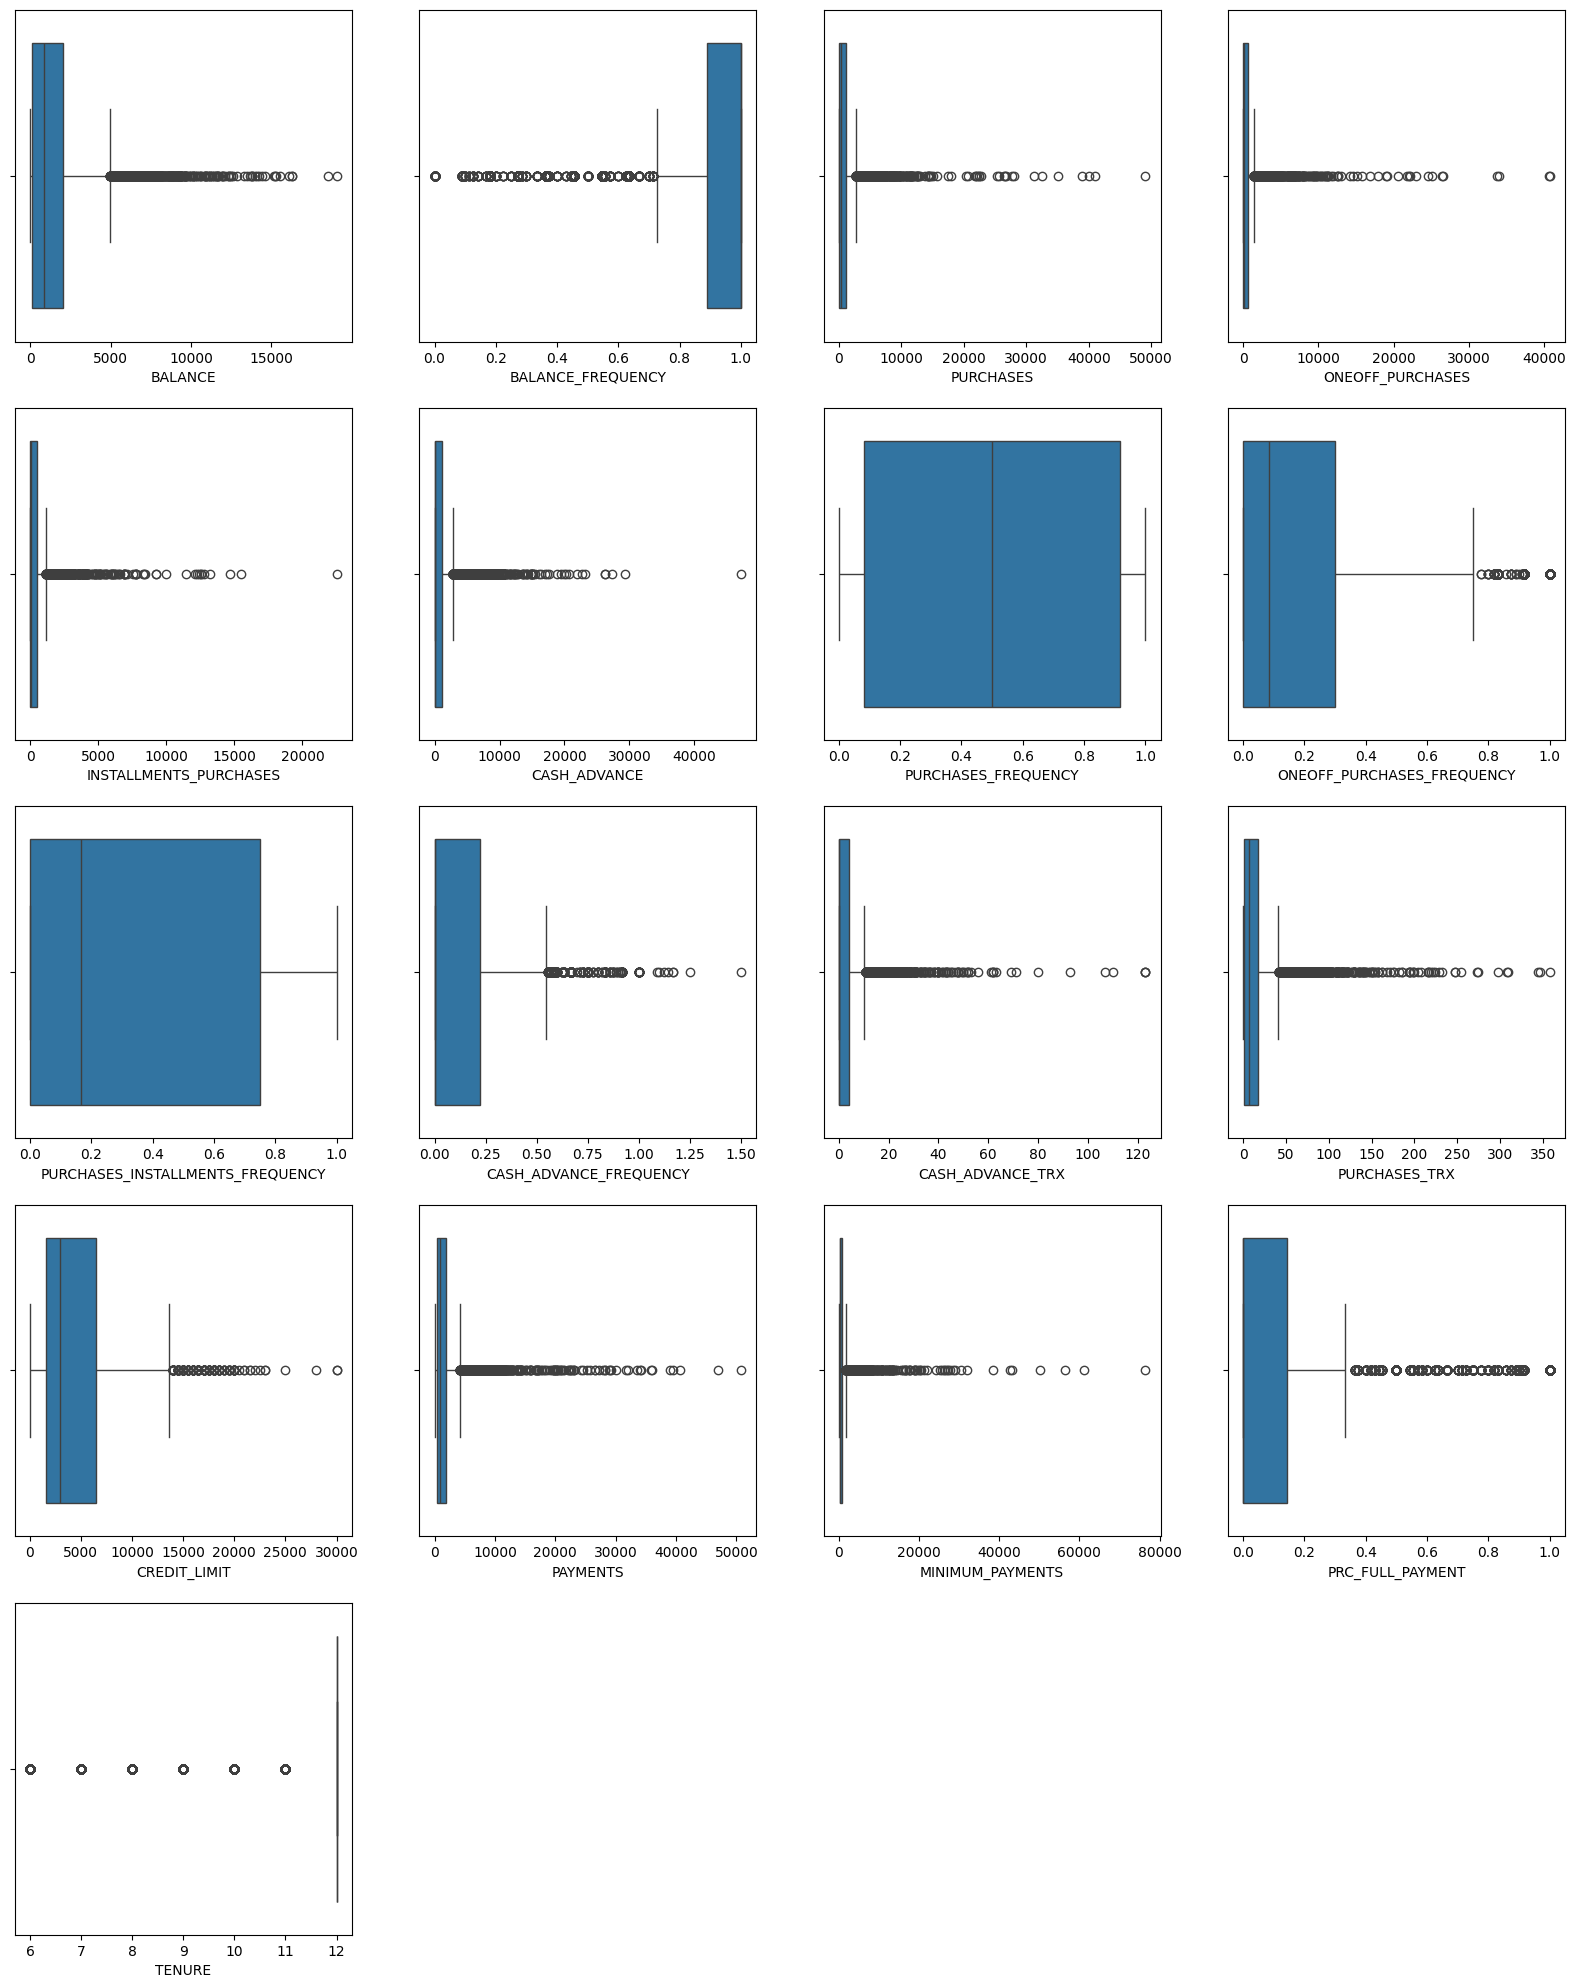

                            Variable  Num_Outliers
0                            BALANCE           695
1                  BALANCE_FREQUENCY          1493
2                          PURCHASES           808
3                   ONEOFF_PURCHASES          1013
4             INSTALLMENTS_PURCHASES           867
5                       CASH_ADVANCE          1030
6                PURCHASES_FREQUENCY             0
7         ONEOFF_PURCHASES_FREQUENCY           782
8   PURCHASES_INSTALLMENTS_FREQUENCY             0
9             CASH_ADVANCE_FREQUENCY           525
10                  CASH_ADVANCE_TRX           804
11                     PURCHASES_TRX           766
12                      CREDIT_LIMIT           248
13                          PAYMENTS           808
14                  MINIMUM_PAYMENTS           841
15                  PRC_FULL_PAYMENT          1474
16                            TENURE          1366


In [4]:
# Plotting with box-plots
def plot_boxplots(df, numerical_cols):
    n = len(numerical_cols)
    n_cols = 4
    n_rows = math.ceil(n / n_cols)
    plt.figure(figsize=(n_cols*5, n_rows*5))
    
    for i, col in enumerate(numerical_cols):
        plt.subplot(n_rows, n_cols , i+1)
        sns.boxplot(x=df[col])
    plt.show()
    
numerical_cols = credit_card.select_dtypes(include=['float64', 'int64']).columns.tolist()
plot_boxplots(credit_card, numerical_cols)

# Understanding the outliers
def num_outliers(df):
    numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    count_outlier = {}
    
    for col in numerical_cols:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        IQR = q3 - q1
        lower_bound = q1 - 1.5 * IQR
        upper_bound = q3 + 1.5 * IQR   
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        count_outlier[col] = outliers.shape[0]
    
    outlier_df = pd.DataFrame(list(count_outlier.items()), columns=['Variable', 'Num_Outliers'])
    return outlier_df

outlier_counts_df = num_outliers(credit_card)
print(outlier_counts_df)

# Correlation Analysis

=== CORRELATION ANALYSIS ===


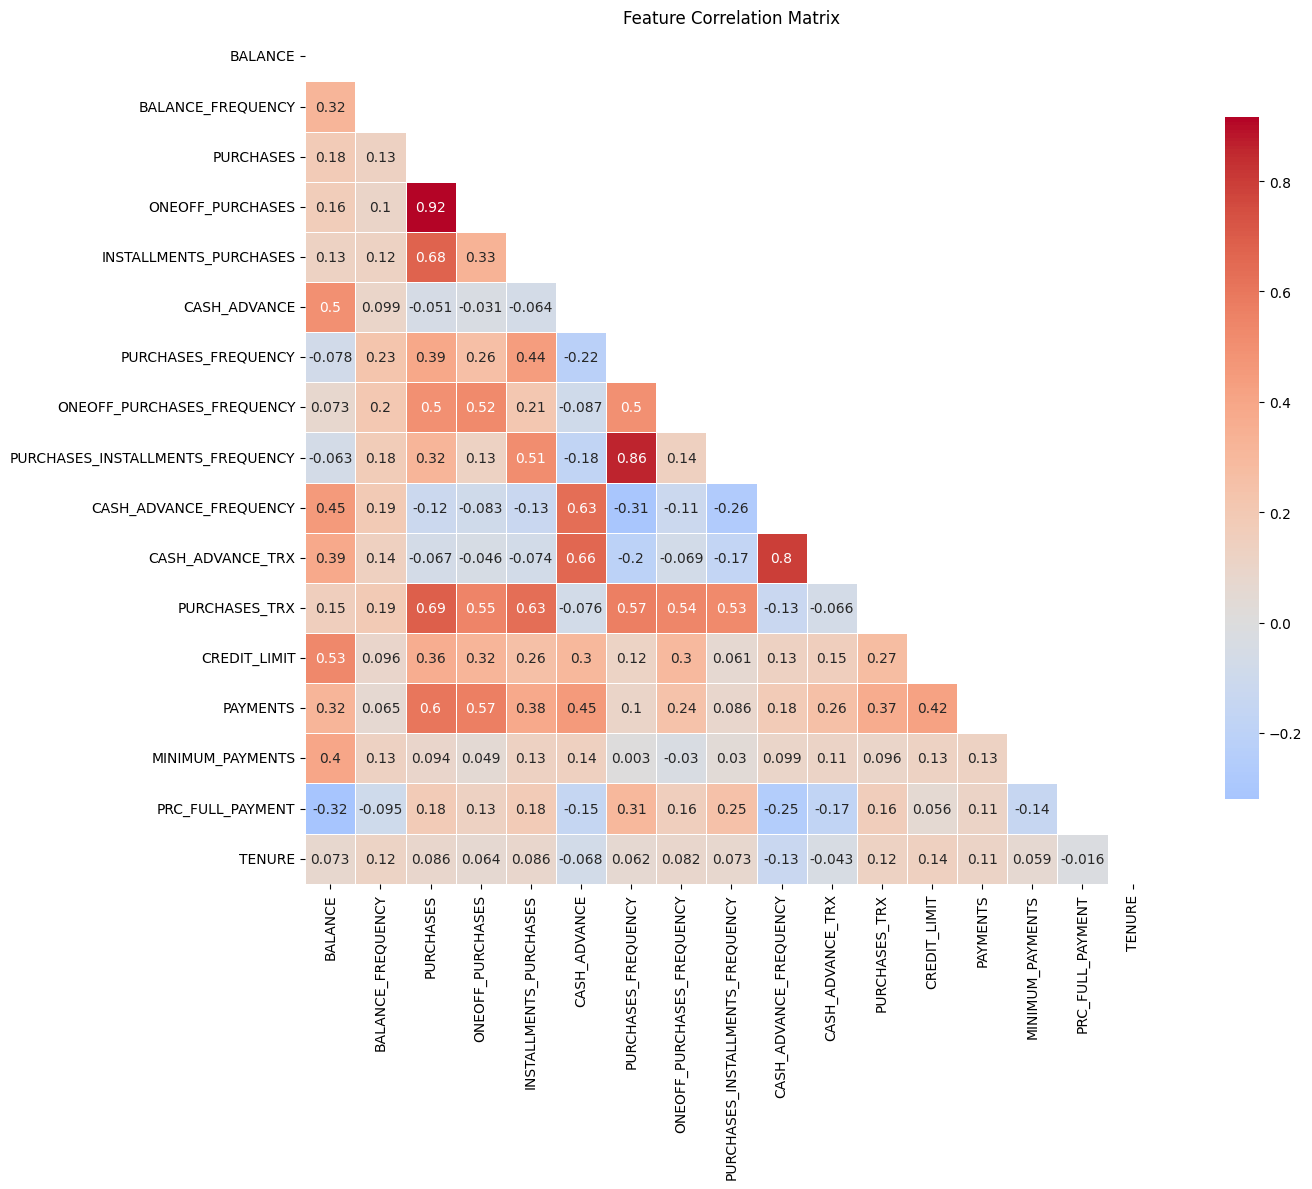


Highly correlated feature pairs (>0.8):
  PURCHASES ↔ ONEOFF_PURCHASES: 0.917
  PURCHASES_FREQUENCY ↔ PURCHASES_INSTALLMENTS_FREQUENCY: 0.863


In [5]:
# Correlation analysis for churn prediction
def correlation_analysis(df):
    """Analyze correlations between features and target"""
    print("=== CORRELATION ANALYSIS ===")
    
    # Select numerical columns for correlation
    numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    
    # Create correlation matrix
    corr_matrix = df[numerical_cols].corr()
    
    # Plot correlation heatmap
    plt.figure(figsize=(16, 12))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
                square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
    plt.title('Feature Correlation Matrix')
    plt.tight_layout()
    plt.show()
    
    # Find highly correlated features
    high_corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) > 0.8:
                high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))
    
    if high_corr_pairs:
        print("\nHighly correlated feature pairs (>0.8):")
        for pair in high_corr_pairs:
            print(f"  {pair[0]} ↔ {pair[1]}: {pair[2]:.3f}")
    
    return corr_matrix

corr_matrix = correlation_analysis(credit_card)

# Distribution Analysis and Skewness

Skewness of numerical variables:
 BALANCE                              2.393386
BALANCE_FREQUENCY                   -2.023266
PURCHASES                            8.144269
ONEOFF_PURCHASES                    10.045083
INSTALLMENTS_PURCHASES               7.299120
CASH_ADVANCE                         5.166609
PURCHASES_FREQUENCY                  0.060164
ONEOFF_PURCHASES_FREQUENCY           1.535613
PURCHASES_INSTALLMENTS_FREQUENCY     0.509201
CASH_ADVANCE_FREQUENCY               1.828686
CASH_ADVANCE_TRX                     5.721298
PURCHASES_TRX                        4.630655
CREDIT_LIMIT                         1.522464
PAYMENTS                             5.907620
MINIMUM_PAYMENTS                    13.622797
PRC_FULL_PAYMENT                     1.942820
TENURE                              -2.943017
dtype: float64


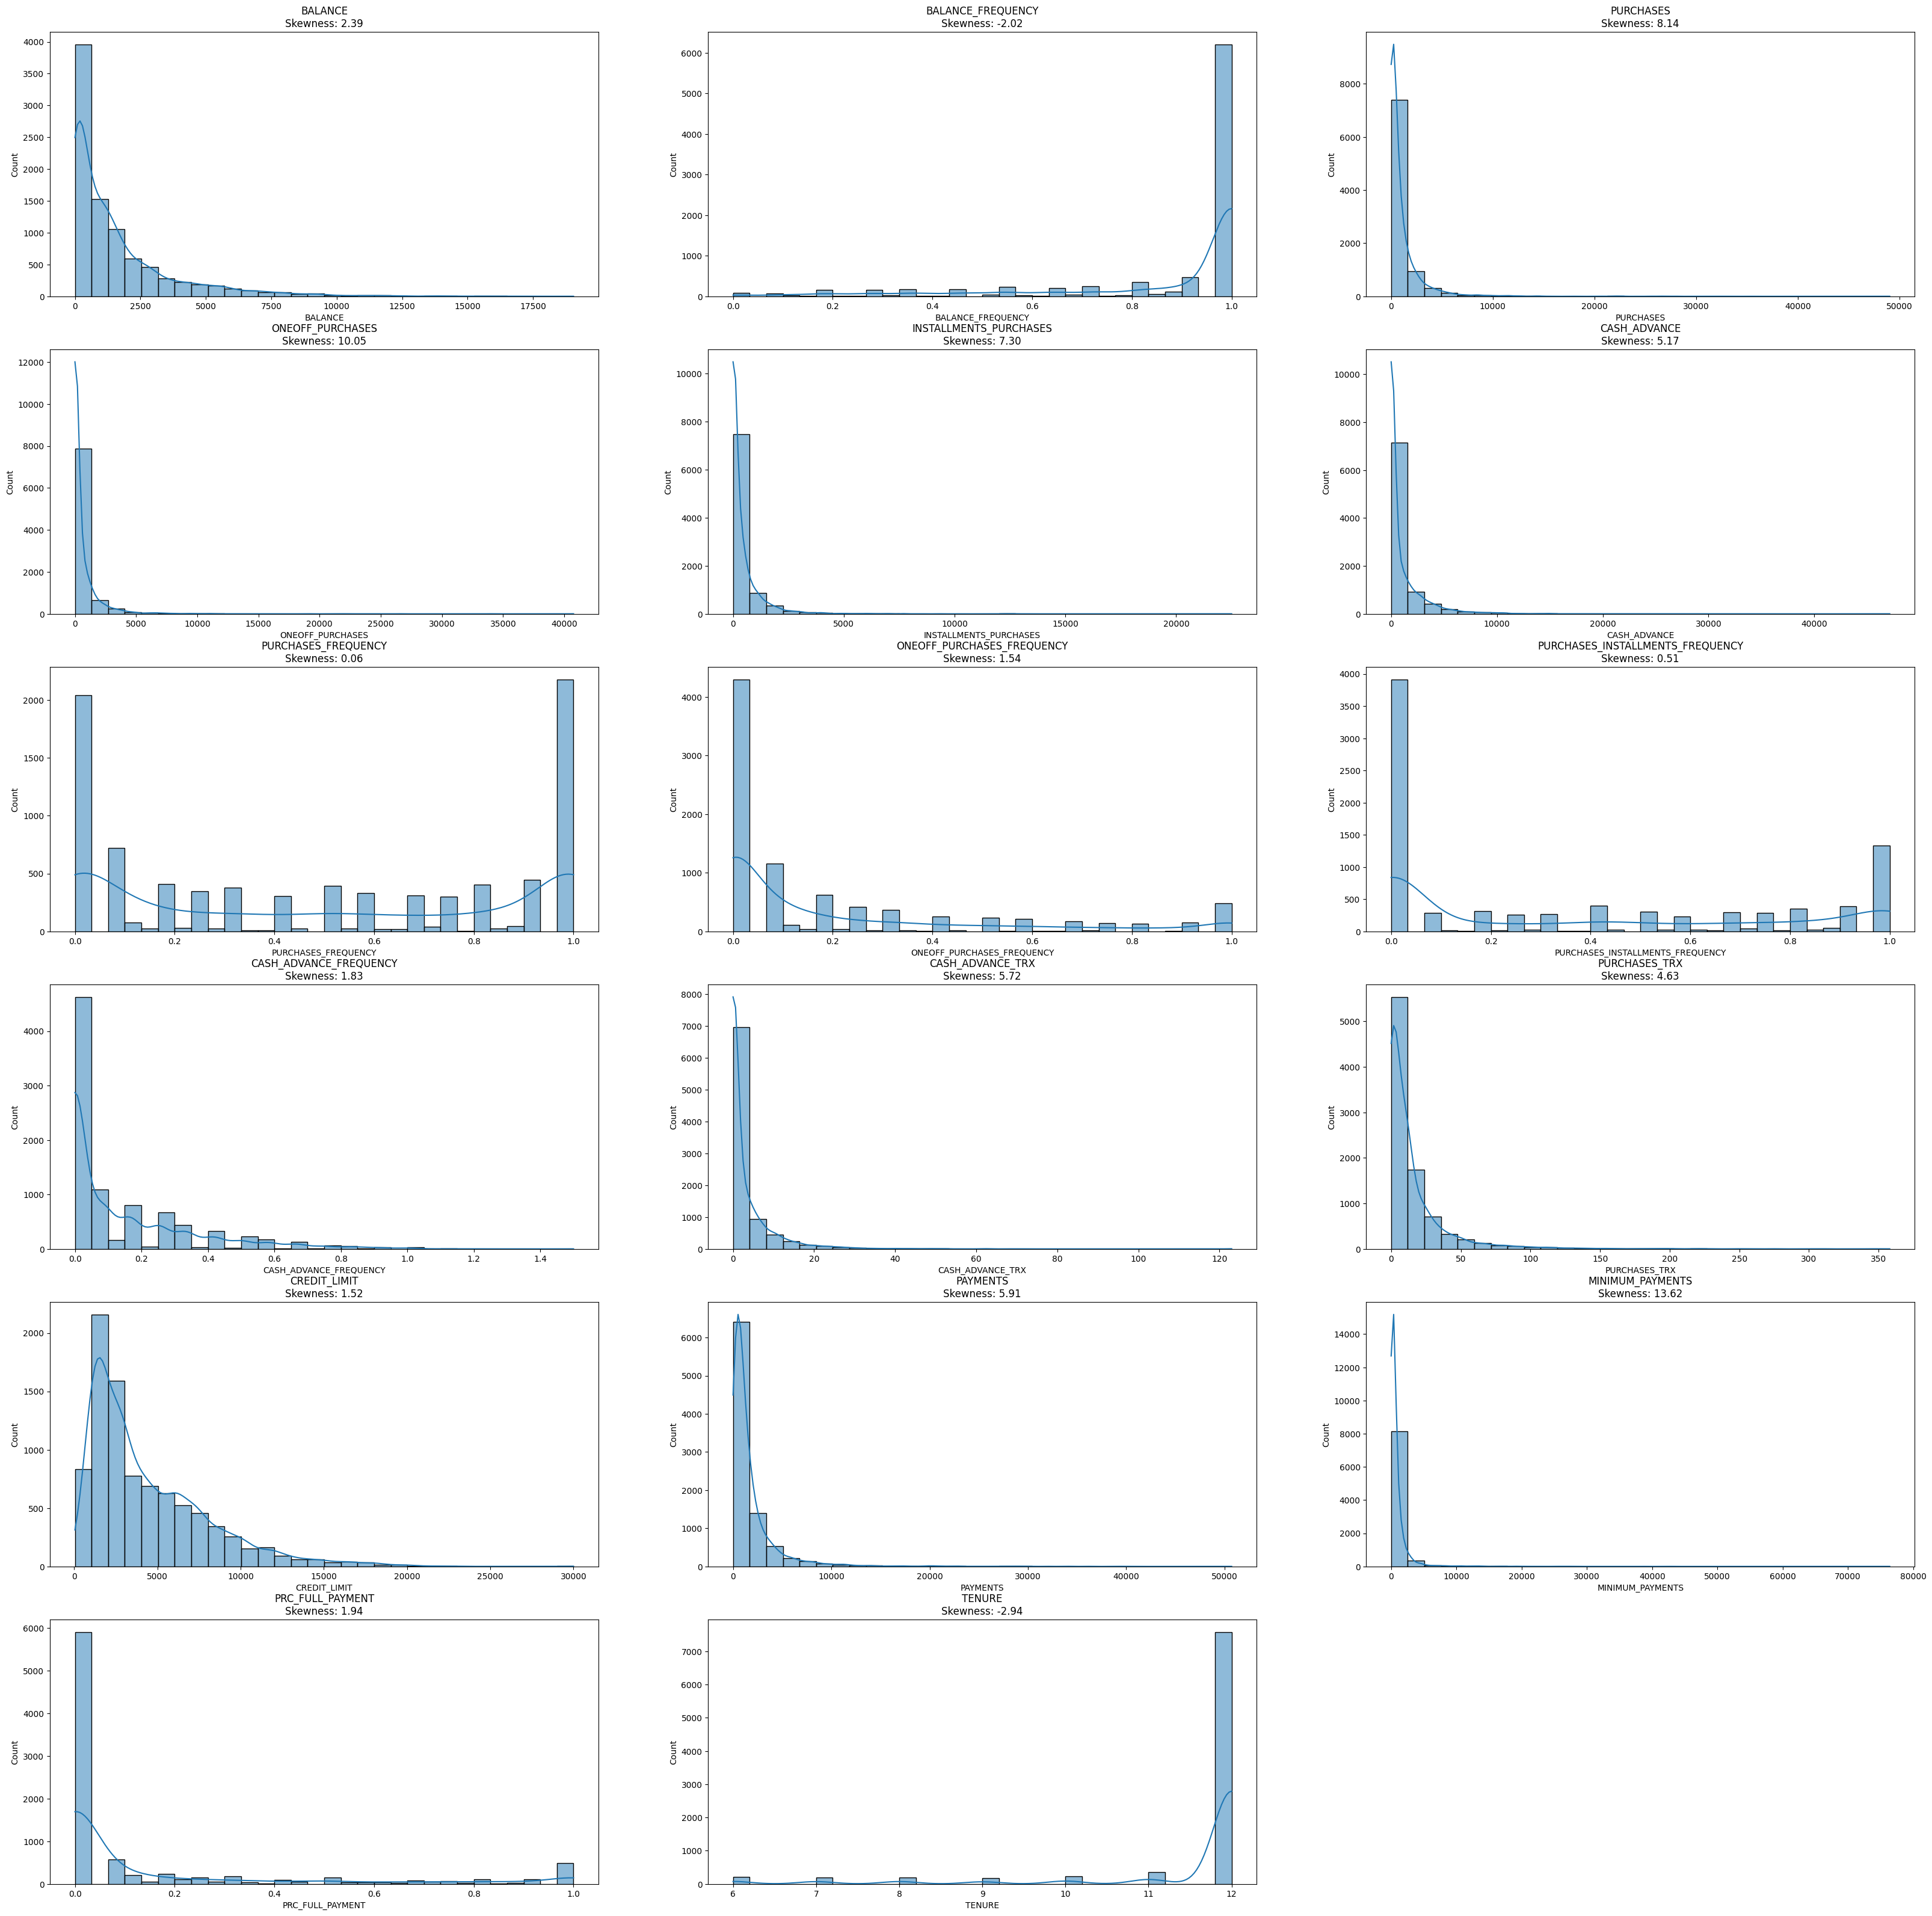

In [6]:
def plot_skewness(df):
    skew_values = df.skew(numeric_only=True)
    print("Skewness of numerical variables:\n", skew_values)

    num_cols = df.select_dtypes(include=['float64', 'int64']).columns

    plt.figure(figsize=(40, 40))
    for i, col in enumerate(num_cols, 1):
        plt.subplot(len(num_cols)//3 + 1, 3, i)  
        sns.histplot(df[col], kde=True, bins=30)
        plt.title(f"{col}\nSkewness: {skew_values[col]:.2f}")
    plt.show()

plot_skewness(credit_card)

# Data Preprocessing - Missing Values and Skewness

In [7]:
def handling_missing_values(df):
    print("\n Missing values in credit card dataset: \n", df.isnull().sum())

handling_missing_values(credit_card)

def impute_missing_values(df):
    df_imputed = df.copy()
    credit_limit_median = df['CREDIT_LIMIT'].median()
    min_payments_median = df['MINIMUM_PAYMENTS'].median()
    
    return df.assign(
        CREDIT_LIMIT=df['CREDIT_LIMIT'].fillna(credit_limit_median),
        MINIMUM_PAYMENTS=df['MINIMUM_PAYMENTS'].fillna(min_payments_median)
    )

credit_df_imputed = impute_missing_values(credit_card)
print(credit_df_imputed.info())

def skewness_transformation(df, skew_threshold=1.0):
    df_trans = df.copy()
    numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
    
    skew_before = df[numeric_cols].skew()
    
    for col in numeric_cols:
        data = df_trans[col]
        skew = skew_before[col]
        
        if abs(skew) <= skew_threshold:
            continue
            
        if skew > 3:
            try:
                if data.min() > 0:
                    trans_data, _ = stats.boxcox(data)
                else:
                    trans_data, _ = stats.yeojohnson(data)
                df_trans[col] = trans_data
            except:
                df_trans[col] = np.log1p(data - data.min())
                
        elif skew < -3:
            df_trans[col] = np.sign(data) * (np.abs(data) ** (1/3))
        else:
            if skew > 0:
                df_trans[col] = np.sqrt(data - data.min() + 1e-6)
            else:
                df_trans[col] = np.sign(data) * np.sqrt(np.abs(data))
    
    skew_after = df_trans[numeric_cols].skew()

    report = pd.DataFrame({
        'Before': skew_before,
        'After': skew_after,
        'Improvement': (skew_before.abs() - skew_after.abs())
    })
    
    return df_trans, report.sort_values('Improvement', ascending=False)

credit_df_transformed, skew_report = skewness_transformation(
    credit_df_imputed,
    skew_threshold=1.0
)
print("Skewness Transformation Report:")
display(skew_report)
print(credit_df_transformed.info())


 Missing values in credit card dataset: 
 CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            -------------- 

,Before,After,Improvement
MINIMUM_PAYMENTS,13.852446,-0.003489,13.848957
ONEOFF_PURCHASES,10.045083,0.115147,9.929936
PURCHASES,8.144269,-0.178677,7.965592
INSTALLMENTS_PURCHASES,7.299120,-0.014843,7.284277
PAYMENTS,5.907620,0.124631,5.782989
CASH_ADVANCE_TRX,5.721298,0.392581,5.328717
CASH_ADVANCE,5.166609,0.188413,4.978196
PURCHASES_TRX,4.630655,0.006058,4.624597
BALANCE,2.393386,0.829500,1.563886
CASH_ADVANCE_FREQUENCY,1.828686,0.708929,1.119757


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   float64
 12  PURCHA

# Data Scaling

In [8]:
def data_scaling(df, standard_cols=None, robust_cols=None, minmax_cols=None):
    if standard_cols is None:
        standard_cols = ['BALANCE', 'PURCHASES', 'ONEOFF_PURCHASES', 
                         'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_TRX',
                         'PAYMENTS', 'MINIMUM_PAYMENTS', 'ONEOFF_PURCHASES_FREQUENCY',
                         'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY',
                         'CASH_ADVANCE_TRX', 'CREDIT_LIMIT']
    if robust_cols is None:
        robust_cols = ['BALANCE_FREQUENCY', 'TENURE']
    if minmax_cols is None:
        minmax_cols = ['PURCHASES_FREQUENCY']
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('std', StandardScaler(), standard_cols),
            ('robust', RobustScaler(), robust_cols),
            ('minmax', MinMaxScaler(), minmax_cols)
        ]
    )
    
    X_scaled = preprocessor.fit_transform(df)
    scaled_df = pd.DataFrame(X_scaled, columns=standard_cols + robust_cols + minmax_cols, index=df.index)
    return scaled_df

credit_df_scaled = data_scaling(credit_df_transformed)
print(credit_df_scaled.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 16 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   BALANCE                           8950 non-null   float64
 1   PURCHASES                         8950 non-null   float64
 2   ONEOFF_PURCHASES                  8950 non-null   float64
 3   INSTALLMENTS_PURCHASES            8950 non-null   float64
 4   CASH_ADVANCE                      8950 non-null   float64
 5   PURCHASES_TRX                     8950 non-null   float64
 6   PAYMENTS                          8950 non-null   float64
 7   MINIMUM_PAYMENTS                  8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   float64
 12  CREDIT

# Churn-Specific Feature Engineering

In [9]:
def churn_feature_engineering(df):
    """Create features specifically for churn prediction"""
    print("Available columns:", list(df.columns))
    
    # Check which columns exist before creating features
    required_columns = [
        'BALANCE', 'CREDIT_LIMIT', 'PAYMENTS', 'PURCHASES', 
        'CASH_ADVANCE', 'BALANCE_FREQUENCY', 'PURCHASES_FREQUENCY',
        'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY'
    ]
    
    missing_columns = [col for col in required_columns if col not in df.columns]
    if missing_columns:
        print(f"Warning: Missing required columns: {missing_columns}")
        return df
    
    # Create features with safe column access
    try:
        # Balance-to-credit-limit ratio
        if 'BALANCE' in df.columns and 'CREDIT_LIMIT' in df.columns:
            df['BALANCE_CREDIT_RATIO'] = df['BALANCE'] / (df['CREDIT_LIMIT'] + 1e-6)
        
        # Payment-to-purchase ratio
        if 'PAYMENTS' in df.columns and 'PURCHASES' in df.columns:
            df['PAYMENT_PURCHASE_RATIO'] = df['PAYMENTS'] / (df['PURCHASES'] + 1)
        
        # Cash advance ratio
        if 'CASH_ADVANCE' in df.columns and 'BALANCE' in df.columns:
            df['CASH_ADVANCE_RATIO'] = df['CASH_ADVANCE'] / (df['BALANCE'] + 1)
        
        # Payment frequency score - check which columns exist
        payment_score_components = []
        if 'BALANCE_FREQUENCY' in df.columns:
            payment_score_components.append(df['BALANCE_FREQUENCY'])
        if 'PURCHASES_FREQUENCY' in df.columns:
            payment_score_components.append(df['PURCHASES_FREQUENCY'])
        
        # Check for PRC_FULL_PAYMENT column (it might have a different name)
        prc_full_payment_col = None
        possible_names = ['PRC_FULL_PAYMENT', 'PRCFULLPAYMENT', 'FULL_PAYMENT_PERCENTAGE']
        for name in possible_names:
            if name in df.columns:
                prc_full_payment_col = name
                break
        
        if prc_full_payment_col:
            payment_score_components.append(df[prc_full_payment_col])
            print(f"Found PRC_FULL_PAYMENT column: {prc_full_payment_col}")
        else:
            print("Warning: PRC_FULL_PAYMENT column not found. Available similar columns:")
            similar_cols = [col for col in df.columns if 'PAYMENT' in col.upper() or 'PRC' in col.upper()]
            print(similar_cols)
        
        # Create payment frequency score
        if len(payment_score_components) >= 2:
            df['PAYMENT_FREQUENCY_SCORE'] = sum(payment_score_components) / len(payment_score_components)
        else:
            df['PAYMENT_FREQUENCY_SCORE'] = 0.5  # Default value
            print("Warning: Could not create PAYMENT_FREQUENCY_SCORE, using default value")
        
        # Spending behavior score
        spending_components = []
        if 'PURCHASES_FREQUENCY' in df.columns:
            spending_components.append(df['PURCHASES_FREQUENCY'])
        if 'ONEOFF_PURCHASES_FREQUENCY' in df.columns:
            spending_components.append(df['ONEOFF_PURCHASES_FREQUENCY'])
        if 'PURCHASES_INSTALLMENTS_FREQUENCY' in df.columns:
            spending_components.append(df['PURCHASES_INSTALLMENTS_FREQUENCY'])
        
        if len(spending_components) >= 2:
            df['SPENDING_BEHAVIOR_SCORE'] = sum(spending_components) / len(spending_components)
        else:
            df['SPENDING_BEHAVIOR_SCORE'] = 0.5  # Default value
            print("Warning: Could not create SPENDING_BEHAVIOR_SCORE, using default value")
        
        # Risk indicators
        if 'CASH_ADVANCE' in df.columns and 'BALANCE_CREDIT_RATIO' in df.columns:
            df['HIGH_RISK_INDICATOR'] = (
                (df['CASH_ADVANCE'] > df['CASH_ADVANCE'].quantile(0.75)) |
                (df['BALANCE_CREDIT_RATIO'] > 0.8)
            ).astype(int)
            
            # Add PRC_FULL_PAYMENT condition if available
            if prc_full_payment_col:
                df['HIGH_RISK_INDICATOR'] = (
                    df['HIGH_RISK_INDICATOR'] |
                    (df[prc_full_payment_col] < 0.5)
                ).astype(int)
        else:
            df['HIGH_RISK_INDICATOR'] = 0
            print("Warning: Could not create HIGH_RISK_INDICATOR, using default value")
        
        if 'CASH_ADVANCE' in df.columns and 'BALANCE_CREDIT_RATIO' in df.columns:
            df['MEDIUM_RISK_INDICATOR'] = (
                (df['CASH_ADVANCE'].between(
                    df['CASH_ADVANCE'].quantile(0.25), 
                    df['CASH_ADVANCE'].quantile(0.75)
                )) |
                (df['BALANCE_CREDIT_RATIO'].between(0.4, 0.8))
            ).astype(int)
        else:
            df['MEDIUM_RISK_INDICATOR'] = 0
            print("Warning: Could not create MEDIUM_RISK_INDICATOR, using default value")
        
        print("Churn-specific features created:")
        new_features = ['BALANCE_CREDIT_RATIO', 'PAYMENT_PURCHASE_RATIO', 'CASH_ADVANCE_RATIO',
                       'PAYMENT_FREQUENCY_SCORE', 'SPENDING_BEHAVIOR_SCORE', 
                       'HIGH_RISK_INDICATOR', 'MEDIUM_RISK_INDICATOR']
        for feature in new_features:
            if feature in df.columns:
                print(f"  ✓ {feature}")
            else:
                print(f"  ✗ {feature} (not created)")
        
        return df
        
    except Exception as e:
        print(f"Error in feature engineering: {e}")
        print("Available columns:", list(df.columns))
        return df

# Apply the feature engineering
credit_df_churn_features = churn_feature_engineering(credit_df_scaled)

Available columns: ['BALANCE', 'PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_TRX', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'CREDIT_LIMIT', 'BALANCE_FREQUENCY', 'TENURE', 'PURCHASES_FREQUENCY']
['PAYMENTS', 'MINIMUM_PAYMENTS', 'PAYMENT_PURCHASE_RATIO']
Churn-specific features created:
  ✓ BALANCE_CREDIT_RATIO
  ✓ PAYMENT_PURCHASE_RATIO
  ✓ CASH_ADVANCE_RATIO
  ✓ PAYMENT_FREQUENCY_SCORE
  ✓ SPENDING_BEHAVIOR_SCORE
  ✓ HIGH_RISK_INDICATOR
  ✓ MEDIUM_RISK_INDICATOR


# Create Churn Target Variable

In [10]:
def create_churn_target(df):
    """Create synthetic target variable for churn prediction"""
    print("=== CREATING CHURN TARGET VARIABLE ===")
    
    # Calculate composite risk score
    risk_score = (
        # Low purchase frequency (negative impact)
        (0.3 - df['PURCHASES_FREQUENCY']).clip(lower=0) * 2 +
        
        # High cash advance usage (positive impact on churn risk)
        (df['CASH_ADVANCE_RATIO'] * 3) +
        
        # Irregular payment patterns (positive impact on churn risk)
        (1 - df['PAYMENT_FREQUENCY_SCORE']) * 2 +
        
        # High balance to credit ratio (positive impact on churn risk)
        (df['BALANCE_CREDIT_RATIO'] * 2) +
        
        # Low payment amounts relative to purchases (positive impact on churn risk)
        (1 - df['PAYMENT_PURCHASE_RATIO']).clip(lower=0) * 1.5 +
        
        # Risk indicators
        df['HIGH_RISK_INDICATOR'] * 3 +
        df['MEDIUM_RISK_INDICATOR'] * 1.5
    )
    
    # Normalize risk score to 0-1 range
    risk_score = (risk_score - risk_score.min()) / (risk_score.max() - risk_score.min())
    
    # Create binary churn target (1 = likely to churn, 0 = likely to stay)
    churn_threshold = risk_score.quantile(0.75)
    df['CHURN_TARGET'] = (risk_score > churn_threshold).astype(int)
    
    print(f"Churn target created:")
    print(f"  - Churn threshold: {churn_threshold:.3f}")
    print(f"  - Churn rate: {df['CHURN_TARGET'].mean():.2%}")
    print(f"  - Non-churn: {(1 - df['CHURN_TARGET']).sum()} customers")
    print(f"  - Churn: {df['CHURN_TARGET'].sum()} customers")
    
    return df

credit_df_with_target = create_churn_target(credit_df_churn_features)

=== CREATING CHURN TARGET VARIABLE ===
Churn target created:
  - Churn threshold: 0.451
  - Churn rate: 25.01%
  - Non-churn: 6712 customers
  - Churn: 2238 customers


# Feature Selection for Churn Prediction

In [11]:
def churn_feature_selection(df, corr_threshold=0.85):
    """Select features for churn prediction model"""
    # Base features as specified in the proposal
    base_features = [
        'TENURE', 'BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES_FREQUENCY',
        'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'CASH_ADVANCE'
    ]
    
    # Add engineered features
    engineered_features = [
        'BALANCE_CREDIT_RATIO', 'PAYMENT_PURCHASE_RATIO', 'CASH_ADVANCE_RATIO',
        'PAYMENT_FREQUENCY_SCORE', 'SPENDING_BEHAVIOR_SCORE',
        'HIGH_RISK_INDICATOR', 'MEDIUM_RISK_INDICATOR'
    ]
    
    # Combine all features
    all_features = base_features + engineered_features
    
    # Check which features exist in the dataset
    available_features = [f for f in all_features if f in df.columns]
    missing_features = [f for f in all_features if f not in df.columns]
    
    if missing_features:
        print(f"Warning: Missing features: {missing_features}")
    
    print(f"Selected features for modeling: {available_features}")
    
    # Select features and target
    X = df[available_features]
    y = df['CHURN_TARGET']
    
    print(f"Feature matrix shape: {X.shape}")
    print(f"Target distribution: {y.value_counts().to_dict()}")
    
    return X, y, available_features

X, y, feature_names = churn_feature_selection(credit_df_with_target)

Selected features for modeling: ['TENURE', 'BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES_FREQUENCY', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'CASH_ADVANCE', 'BALANCE_CREDIT_RATIO', 'PAYMENT_PURCHASE_RATIO', 'CASH_ADVANCE_RATIO', 'PAYMENT_FREQUENCY_SCORE', 'SPENDING_BEHAVIOR_SCORE', 'HIGH_RISK_INDICATOR', 'MEDIUM_RISK_INDICATOR']
Feature matrix shape: (8950, 14)
Target distribution: {0: 6712, 1: 2238}


# Data Splitting and Model Training

In [12]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")
print(f"Training churn rate: {y_train.mean():.2%}")
print(f"Testing churn rate: {y_test.mean():.2%}")

# Define models to try
models = {
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42, n_estimators=100),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000)
}

# Train and evaluate models
best_score = 0
best_model_name = None
best_model = None

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Create pipeline with scaling
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', model)
    ])
    
    # Perform cross-validation
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='roc_auc')
    
    print(f"  Cross-validation ROC-AUC scores: {cv_scores}")
    print(f"  Mean CV score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    
    if cv_scores.mean() > best_score:
        best_score = cv_scores.mean()
        best_model_name = name
        best_model = pipeline

print(f"\nBest model: {best_model_name} (CV ROC-AUC: {best_score:.4f})")

# Train the best model on full training data
best_model.fit(X_train, y_train)

Training set: 7160 samples
Testing set: 1790 samples
Training churn rate: 25.00%
Testing churn rate: 25.03%

Training Random Forest...


  Cross-validation ROC-AUC scores: [0.99830035 0.99836408 0.99776198 0.99861766 0.99786732]
  Mean CV score: 0.9982 (+/- 0.0006)

Training Gradient Boosting...
  Cross-validation ROC-AUC scores: [0.99855134 0.99927697 0.99816121 0.99866057 0.99800776]
  Mean CV score: 0.9985 (+/- 0.0009)

Training Logistic Regression...
  Cross-validation ROC-AUC scores: [0.99031189 0.9753831  0.9756822  0.97641303 0.97828563]
  Mean CV score: 0.9792 (+/- 0.0113)

Best model: Gradient Boosting (CV ROC-AUC: 0.9985)


,steps,"[('scaler', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,loss,'log_loss'
,learning_rate,0.1
,n_estimators,100
,subsample,1.0


# Churn Visualisations

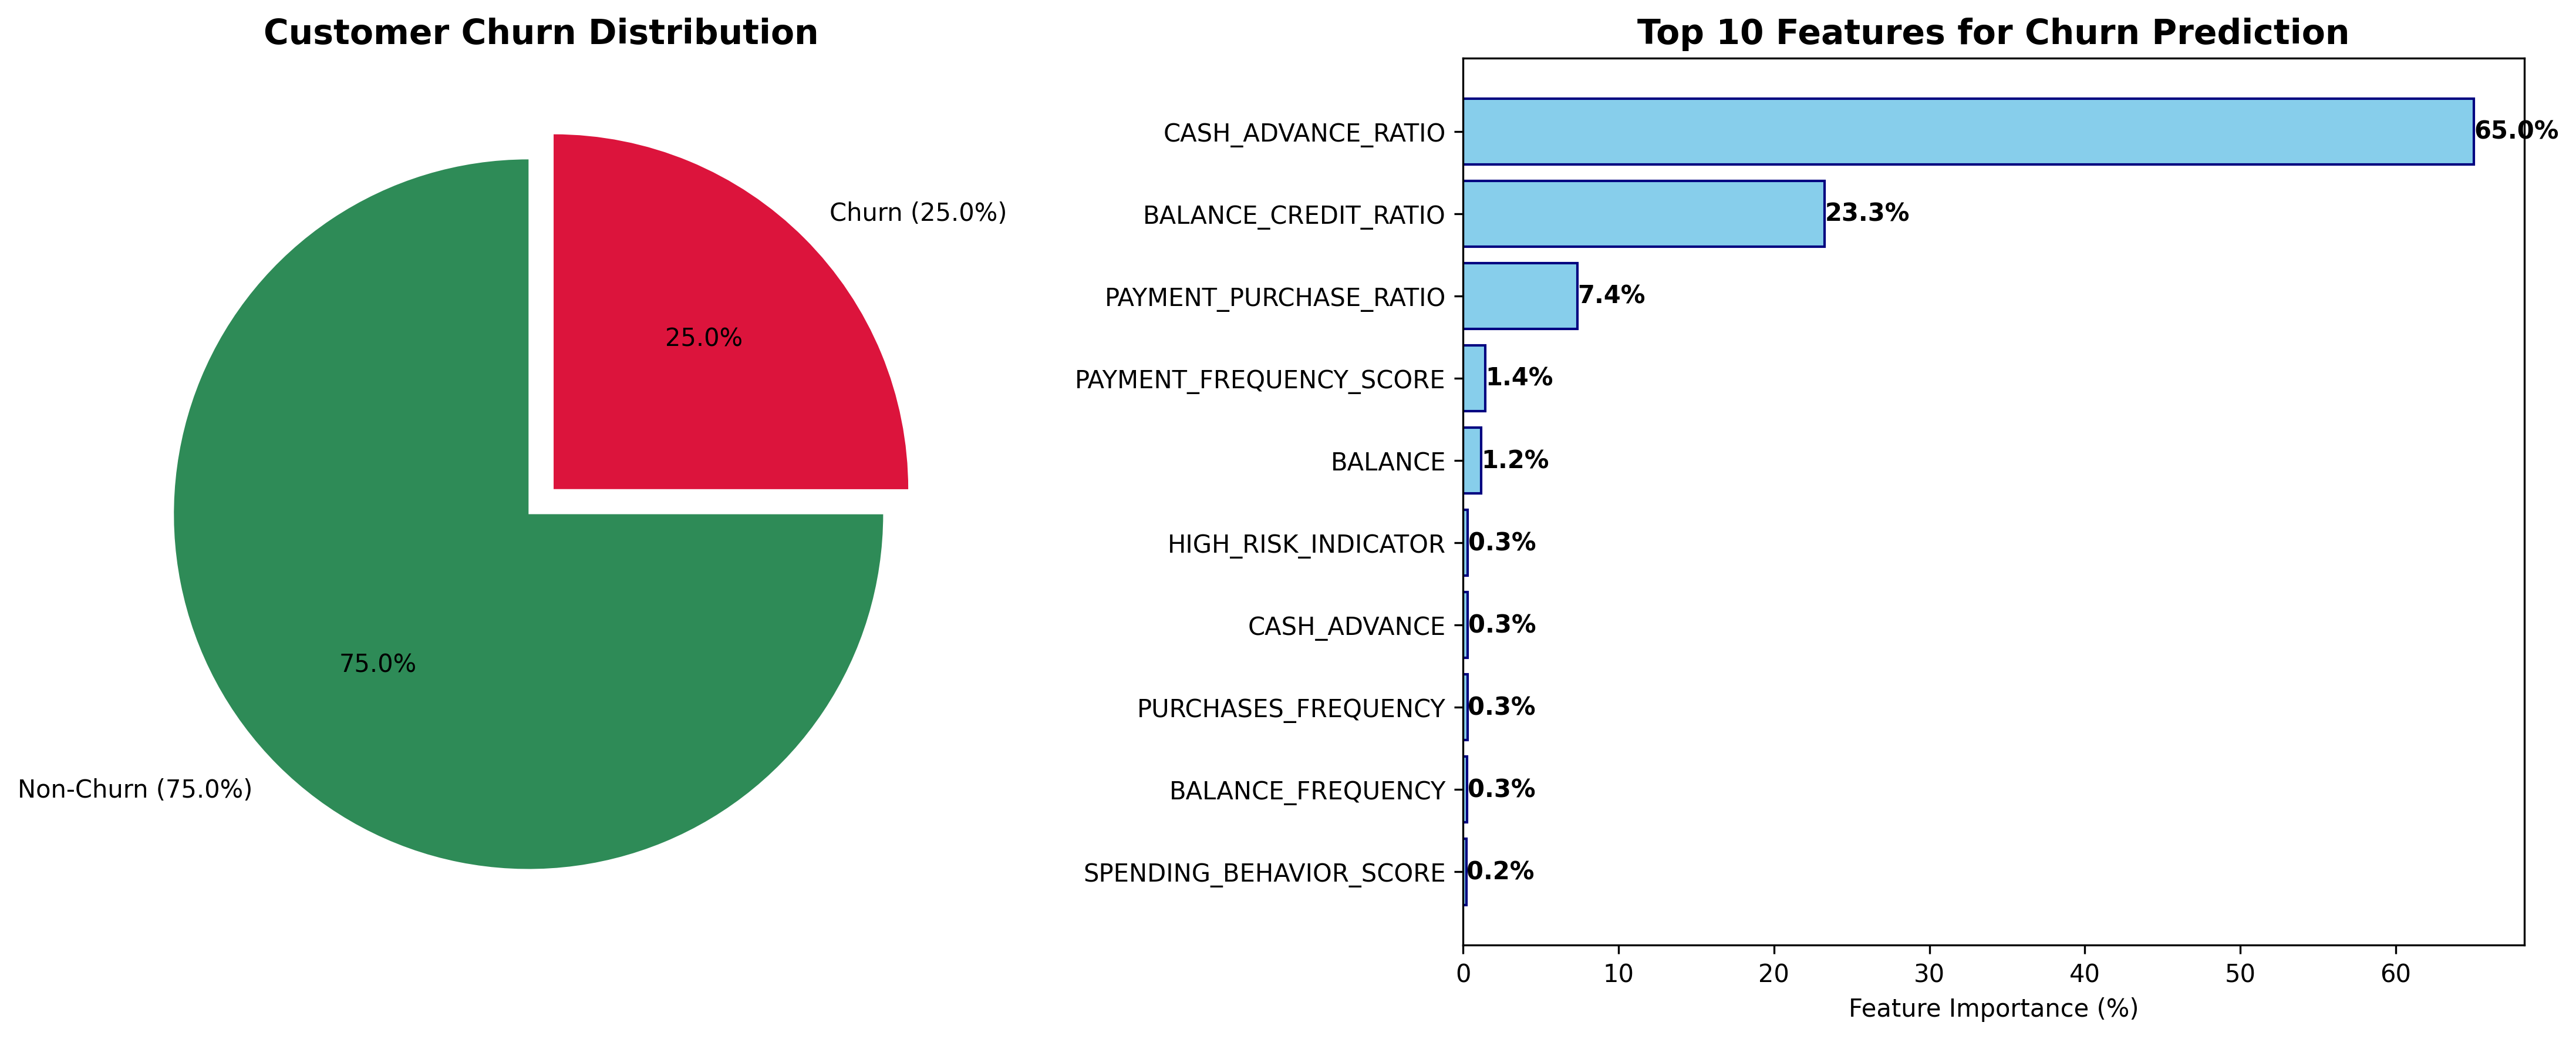

In [13]:
# Set professional styling
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

# 1. Churn Rate Distribution Pie Chart
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Pie chart for churn distribution
churn_counts = [y.value_counts()[0], y.value_counts()[1]]
churn_labels = [f'Non-Churn ({churn_counts[0]/len(y)*100:.1f}%)', 
                f'Churn ({churn_counts[1]/len(y)*100:.1f}%)']
colors = ['#2E8B57', '#DC143C']

ax1.pie(churn_counts, labels=churn_labels, colors=colors, autopct='%1.1f%%', 
        startangle=90, explode=(0.05, 0.05))
ax1.set_title('Customer Churn Distribution', fontsize=14, fontweight='bold')

# 2. Feature Importance Bar Chart
if hasattr(best_model.named_steps['classifier'], 'feature_importances_'):
    importance = best_model.named_steps['classifier'].feature_importances_
else:
    importance = np.abs(best_model.named_steps['classifier'].coef_[0])

# Create feature importance dataframe
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
}).sort_values('Importance', ascending=False)

top_10_features = feature_importance_df.head(10)
bars = ax2.barh(range(len(top_10_features)), top_10_features['Importance']*100, 
                color='skyblue', edgecolor='navy')
ax2.set_yticks(range(len(top_10_features)))
ax2.set_yticklabels(top_10_features['Feature'])
ax2.set_xlabel('Feature Importance (%)')
ax2.set_title('Top 10 Features for Churn Prediction', fontsize=14, fontweight='bold')
ax2.invert_yaxis()

# Add value labels on bars
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax2.text(width + 0.01, bar.get_y() + bar.get_height()/2, f'{width:.1f}%', 
             ha='left', va='center', fontweight='bold')

plt.tight_layout()
plt.savefig('img/churn_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Model Evaluation

In [14]:
# Evaluate the best model on the test set
print("=== MODEL EVALUATION ===")

# Make predictions
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Calculate metrics
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Test Set Performance:")
print(f"  ROC-AUC Score: {roc_auc:.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Non-Churn', 'Churn']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(f"\nConfusion Matrix:")
print(cm)

# Calculate additional metrics
tn, fp, fn, tp = cm.ravel()
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"\nAdditional Metrics:")
print(f"  Accuracy: {accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall: {recall:.4f}")
print(f"  F1-Score: {f1:.4f}")

=== MODEL EVALUATION ===
Test Set Performance:
  ROC-AUC Score: 0.9994

Classification Report:
              precision    recall  f1-score   support

   Non-Churn       0.99      0.99      0.99      1342
       Churn       0.98      0.97      0.98       448

    accuracy                           0.99      1790
   macro avg       0.99      0.98      0.99      1790
weighted avg       0.99      0.99      0.99      1790


Confusion Matrix:
[[1335    7]
 [  12  436]]

Additional Metrics:
  Accuracy: 0.9894
  Precision: 0.9842
  Recall: 0.9732
  F1-Score: 0.9787


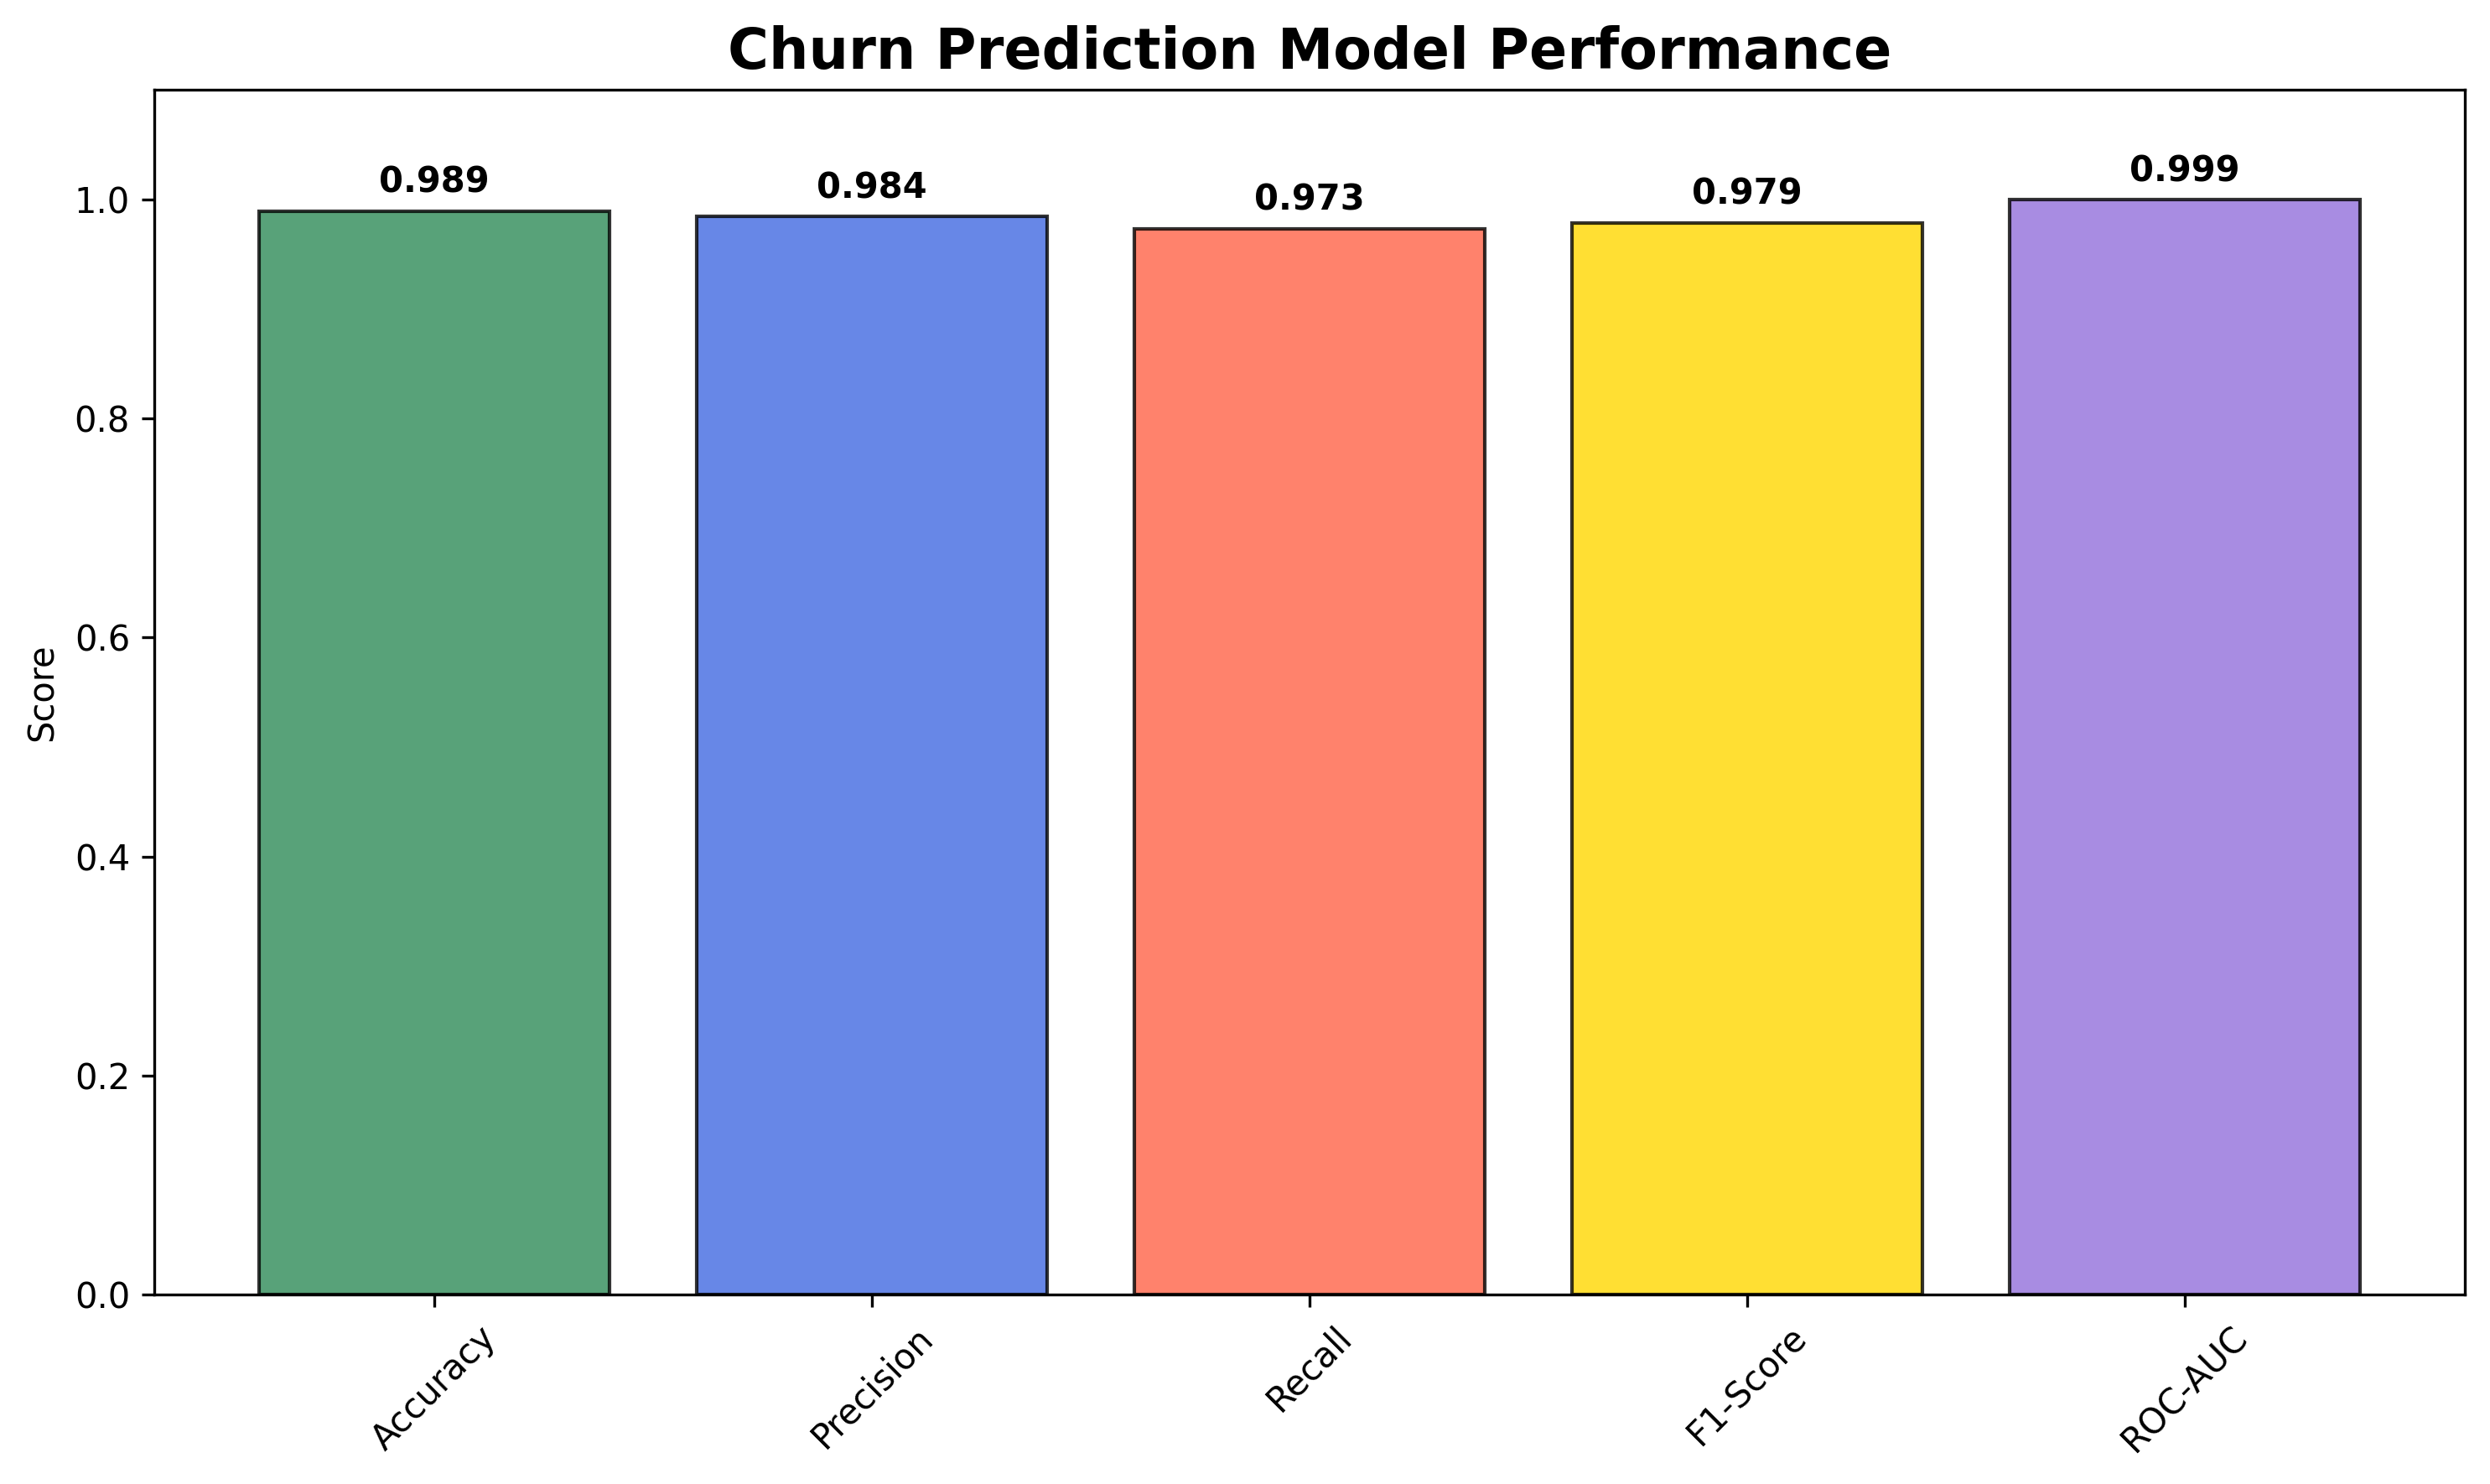

In [17]:
# Model Performance Metrics Visualization
fig, ax = plt.subplots(figsize=(10, 6))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
scores = [accuracy, precision, recall, f1, roc_auc]
colors = ['#2E8B57', '#4169E1', '#FF6347', '#FFD700', '#9370DB']

bars = ax.bar(metrics, scores, color=colors, alpha=0.8, edgecolor='black')
ax.set_ylabel('Score')
ax.set_title('Churn Prediction Model Performance', fontsize=16, fontweight='bold')
ax.set_ylim(0, 1.1)

# Add value labels on bars
for bar, score in zip(bars, scores):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{score:.3f}', ha='center', va='bottom', fontweight='bold')

plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('img/model_performance.png', dpi=300, bbox_inches='tight')
plt.show()

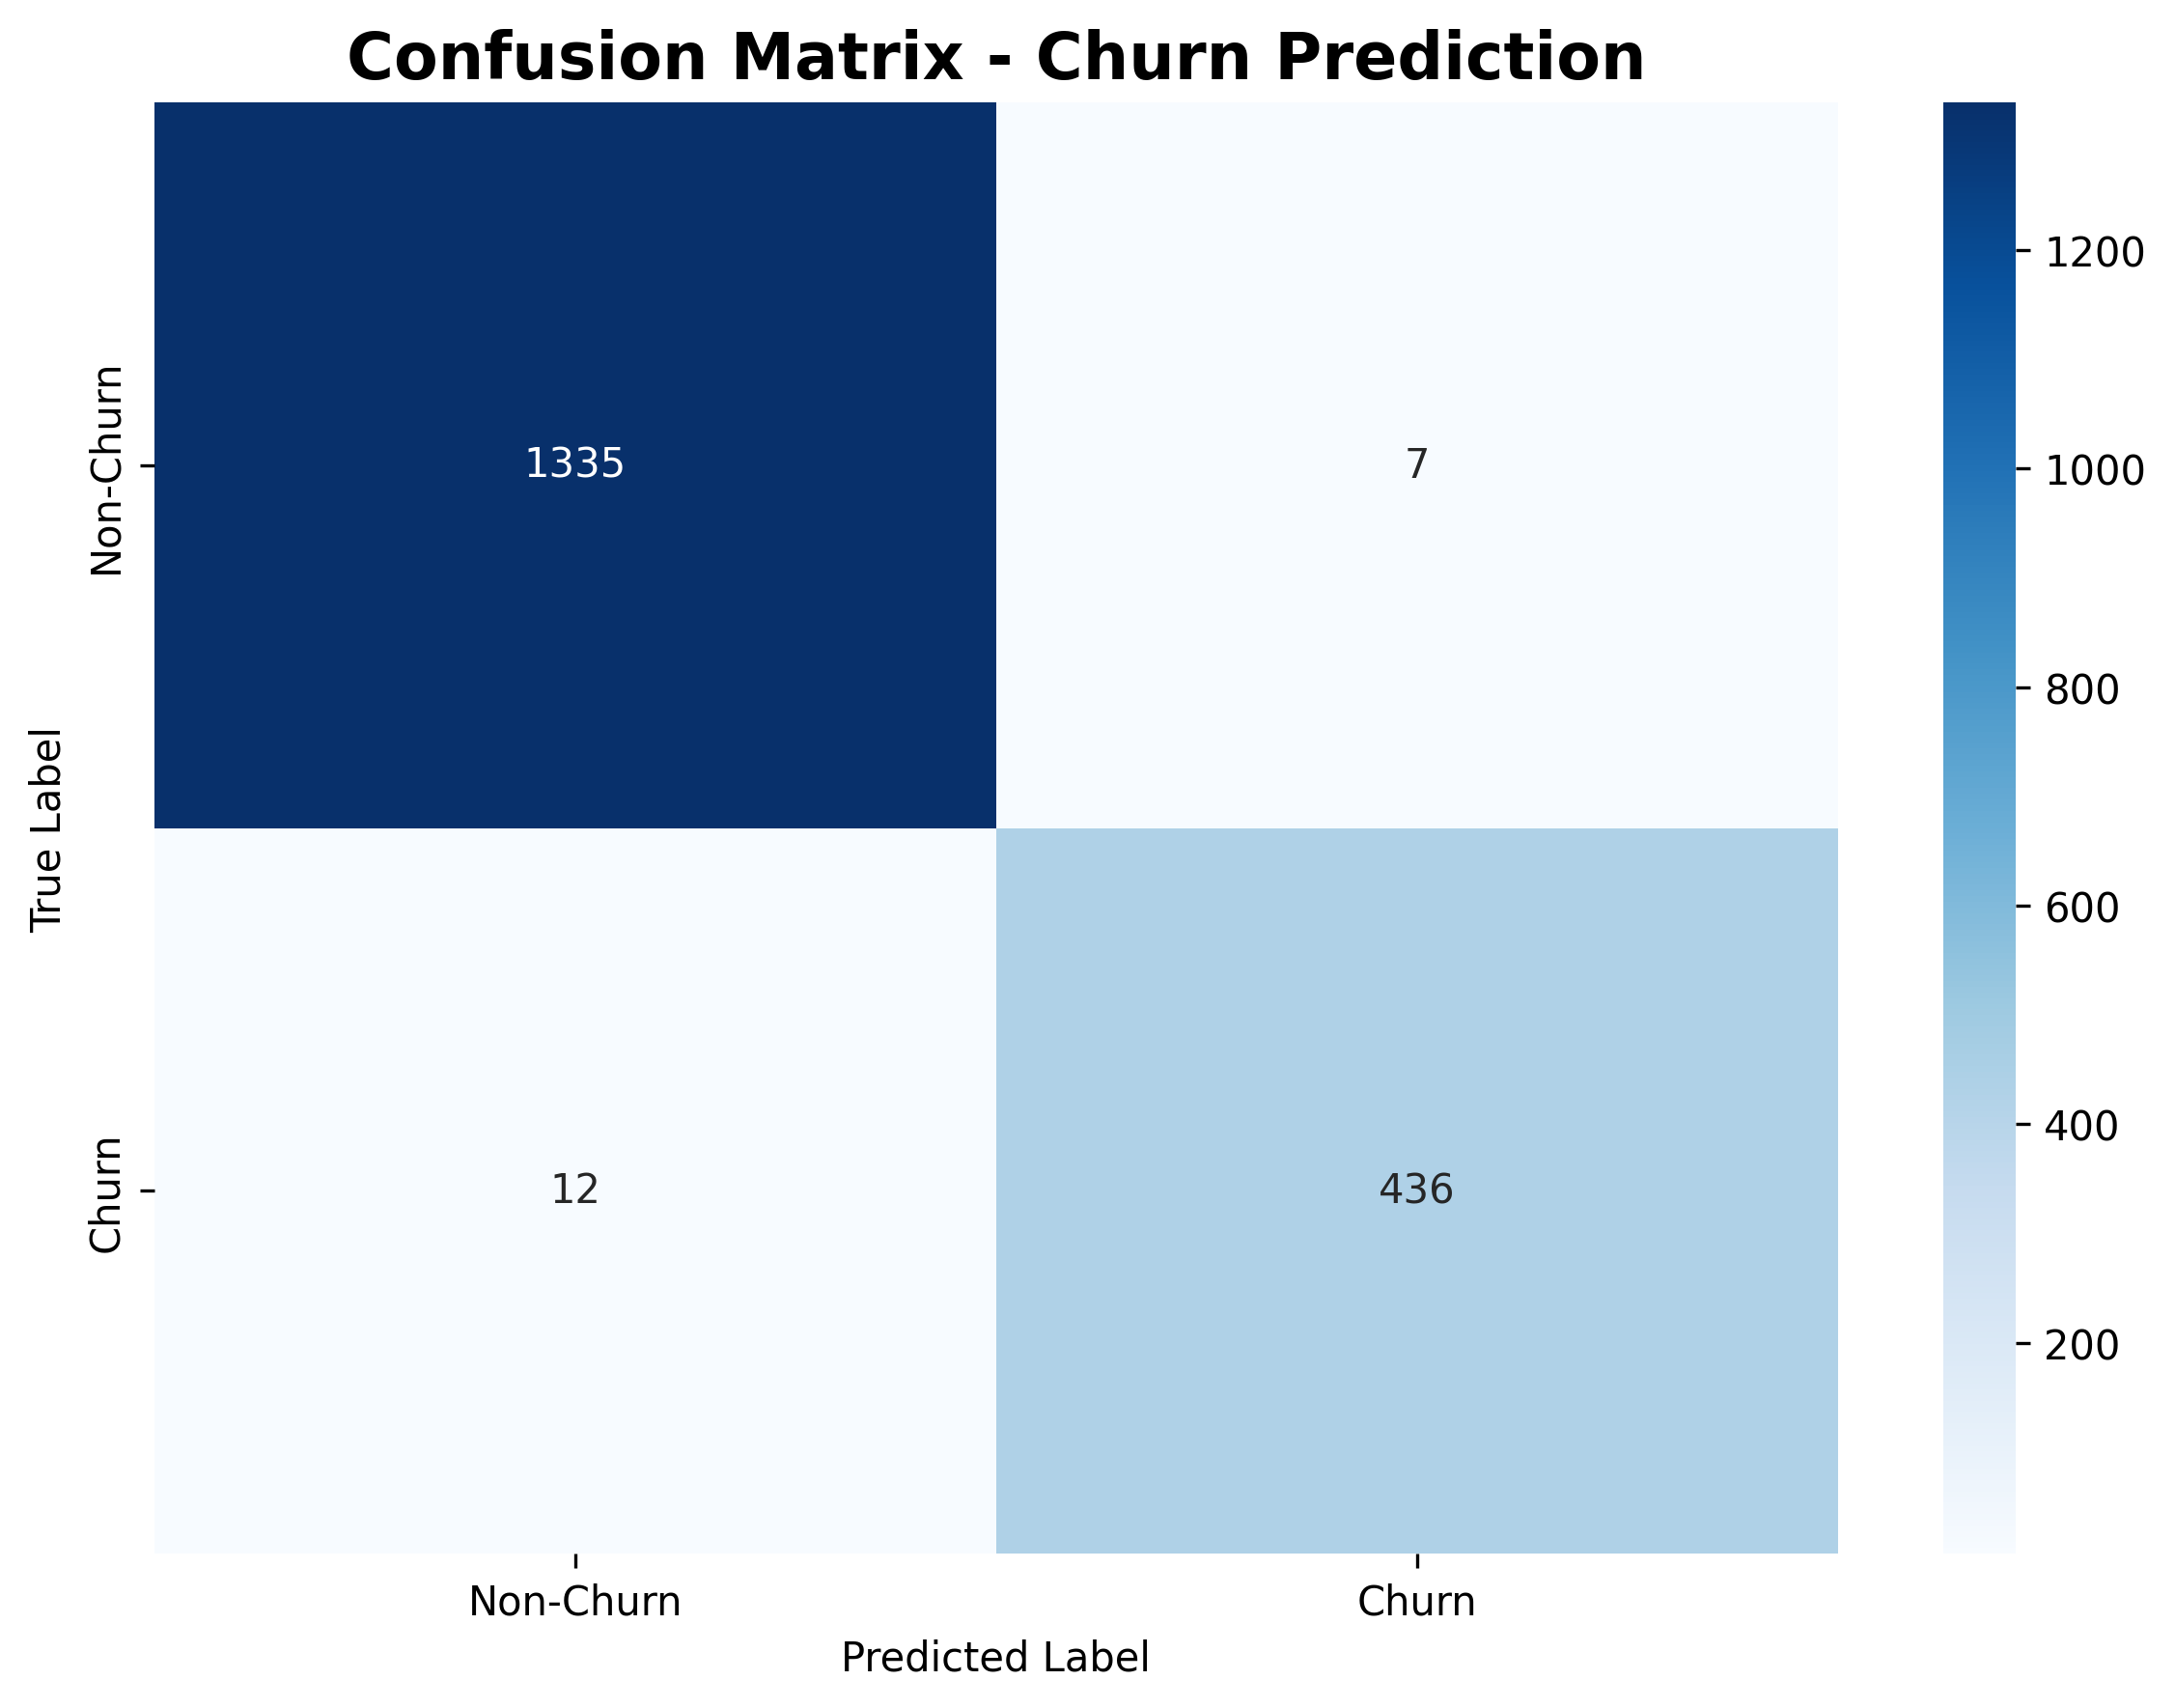

In [18]:
# Confusion Matrix Heatmap
fig, ax = plt.subplots(figsize=(8, 6))

# Use the actual confusion matrix from evaluation
cm = confusion_matrix(y_test, y_pred)
cm_labels = ['Non-Churn', 'Churn']

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=cm_labels, yticklabels=cm_labels, ax=ax)
ax.set_title('Confusion Matrix - Churn Prediction', fontsize=16, fontweight='bold')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')

plt.tight_layout()
plt.savefig('img/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Feature Importance Analysis

=== FEATURE IMPORTANCE ANALYSIS ===
Feature Importance (Top 10):
                    Feature  Importance
9        CASH_ADVANCE_RATIO    0.650194
7      BALANCE_CREDIT_RATIO    0.232684
8    PAYMENT_PURCHASE_RATIO    0.073696
10  PAYMENT_FREQUENCY_SCORE    0.014231
1                   BALANCE    0.011689
12      HIGH_RISK_INDICATOR    0.003135
6              CASH_ADVANCE    0.003130
3       PURCHASES_FREQUENCY    0.002894
2         BALANCE_FREQUENCY    0.002758
11  SPENDING_BEHAVIOR_SCORE    0.002176


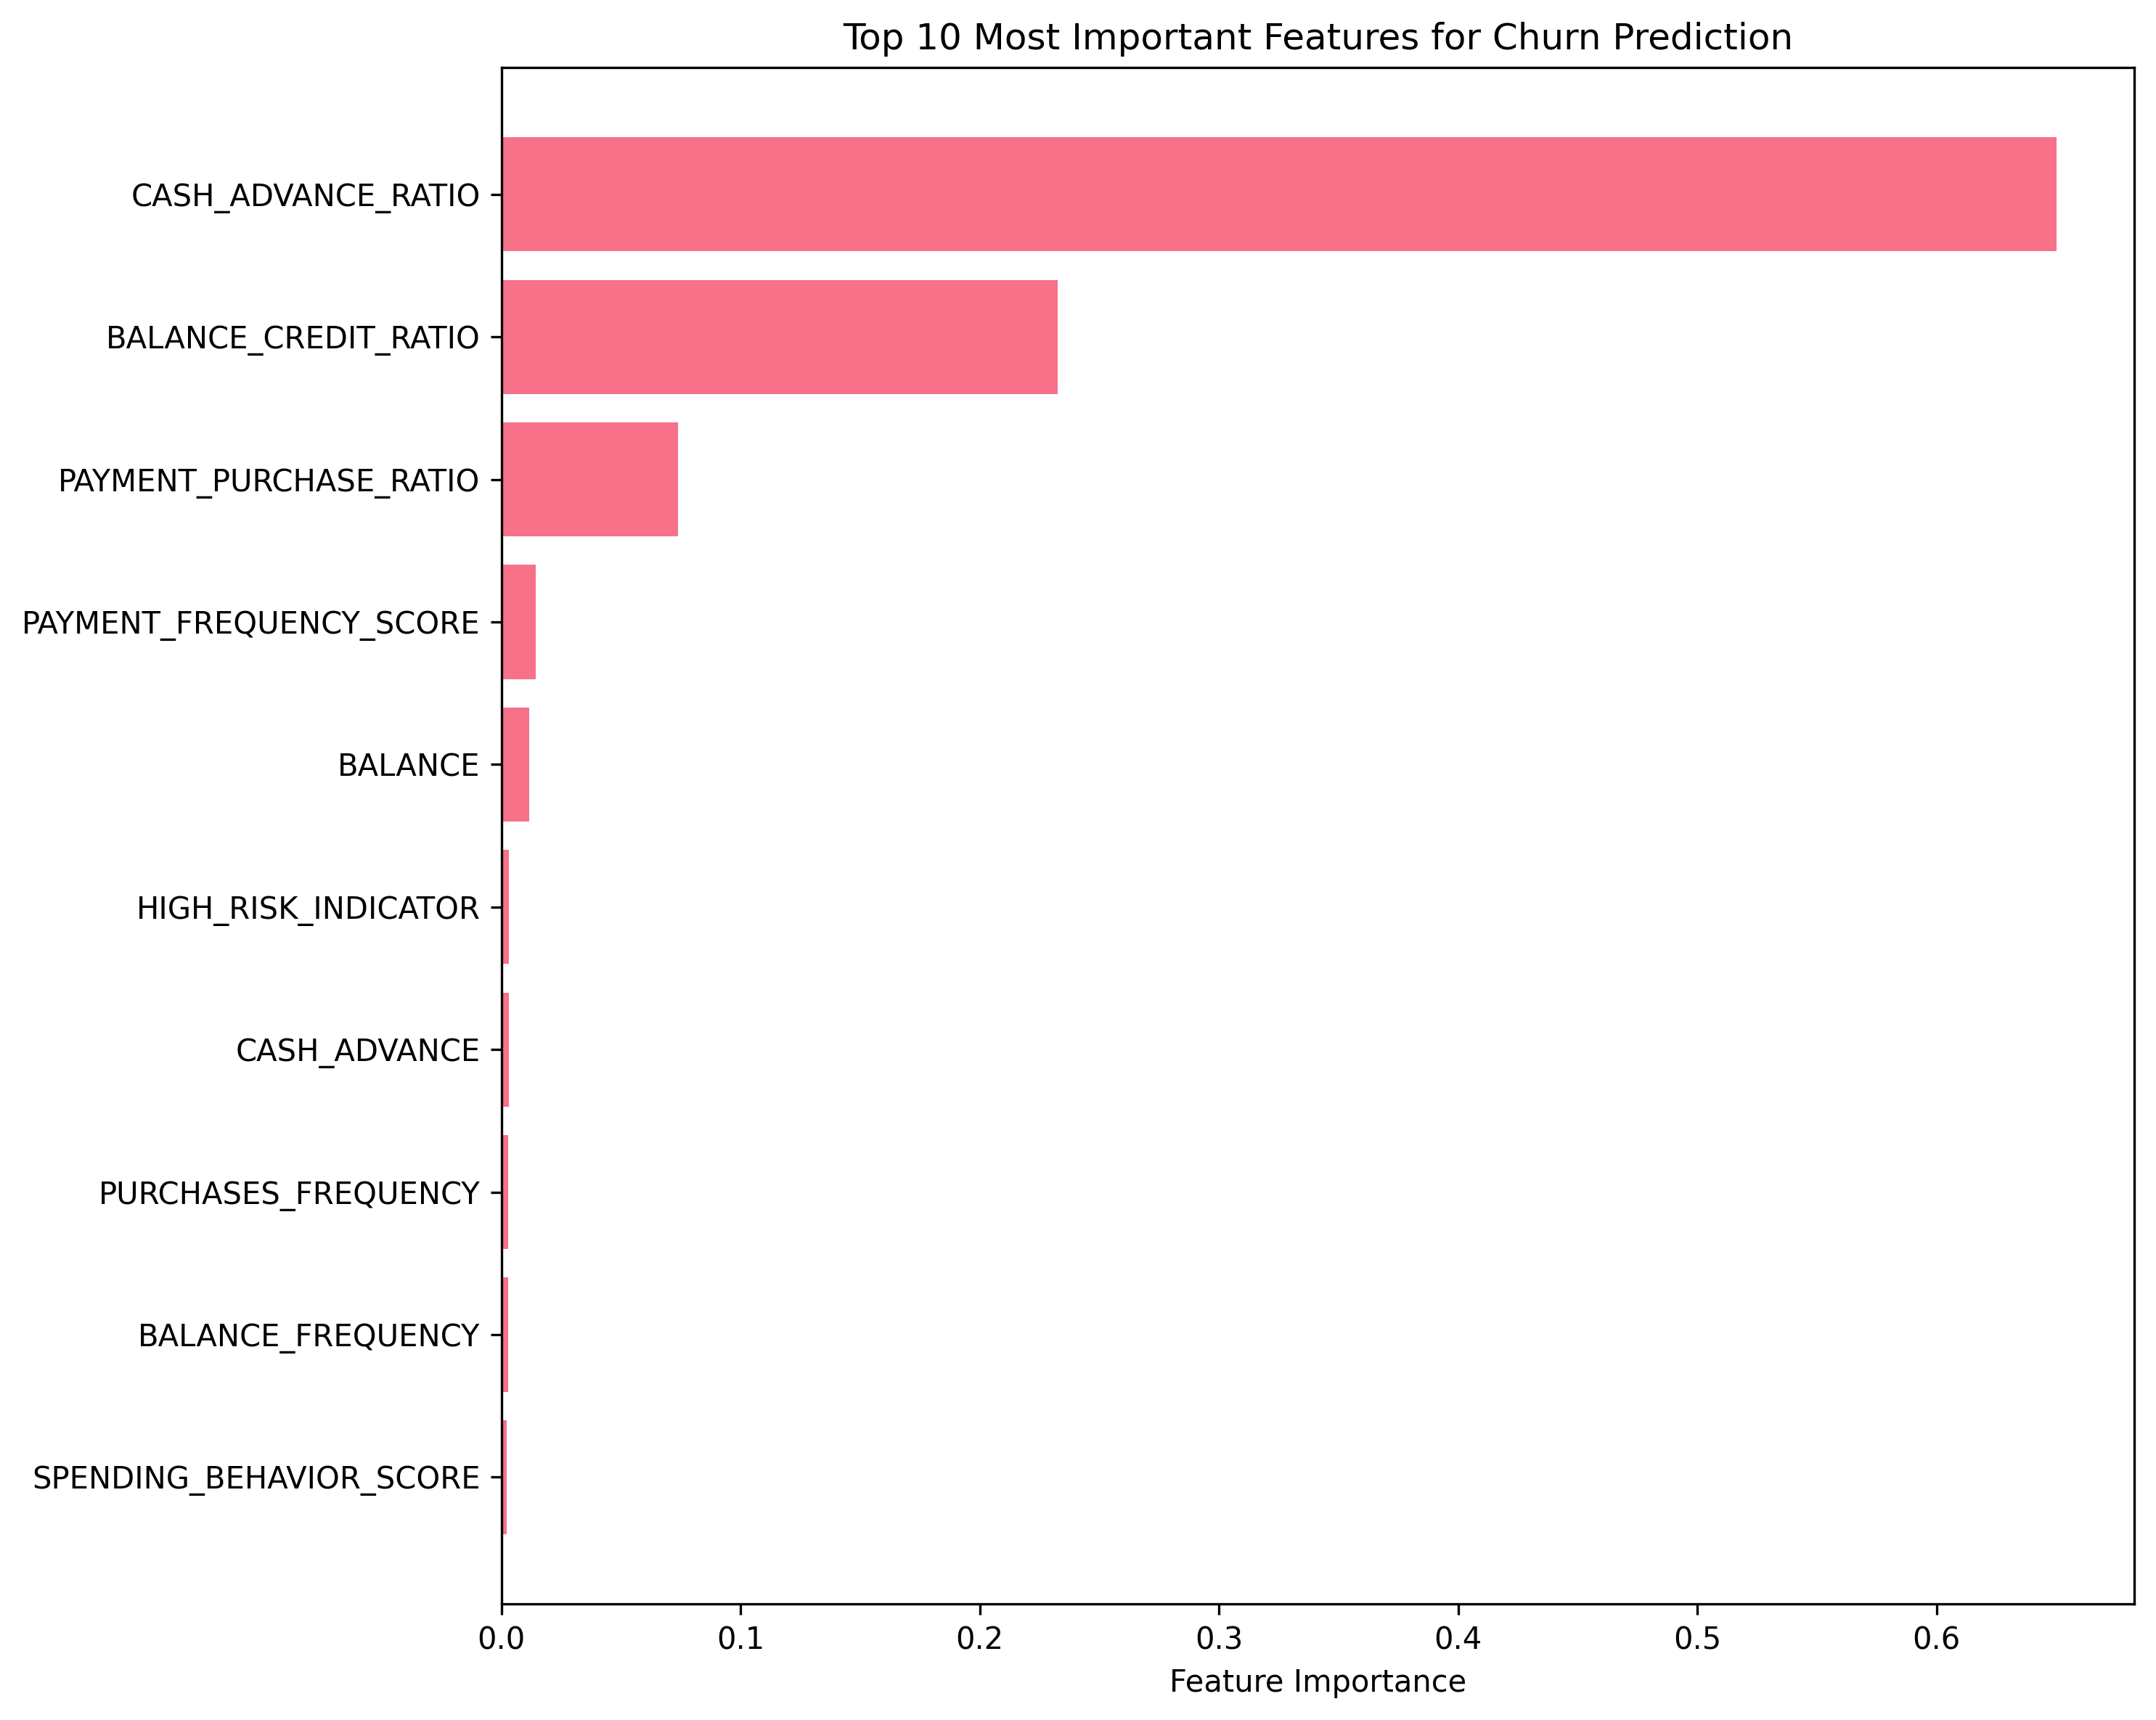

In [20]:
# Analyze and display feature importance
print("=== FEATURE IMPORTANCE ANALYSIS ===")

# Get feature importance
if hasattr(best_model.named_steps['classifier'], 'feature_importances_'):
    # Tree-based models
    importance = best_model.named_steps['classifier'].feature_importances_
elif hasattr(best_model.named_steps['classifier'], 'coef_'):
    # Linear models
    importance = np.abs(best_model.named_steps['classifier'].coef_[0])
else:
    print("Cannot extract feature importance from this model type.")

# Create feature importance dataframe
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
}).sort_values('Importance', ascending=False)

print("Feature Importance (Top 10):")
print(feature_importance_df.head(10))

# Plot feature importance
plt.figure(figsize=(10, 8))
top_features = feature_importance_df.head(10)
plt.barh(range(len(top_features)), top_features['Importance'])
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Feature Importance')
plt.title('Top 10 Most Important Features for Churn Prediction')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.tight_layout()
plt.savefig('img/important_features.png', dpi=300, bbox_inches='tight')
plt.show()

# Example Predictions

In [16]:
# Example of using the trained model for prediction
print("=== EXAMPLE PREDICTIONS ===")

def predict_churn_probability(customer_data):
    """Predict churn probability for new customer data"""
    # Convert to DataFrame
    customer_df = pd.DataFrame([customer_data])
    
    # Ensure all required features are present
    missing_features = set(feature_names) - set(customer_df.columns)
    if missing_features:
        print(f"Missing features: {missing_features}")
        return None
    
    # Select only the required features in the correct order
    customer_df = customer_df[feature_names]
    
    # Make prediction
    churn_prob = best_model.predict_proba(customer_df)[0, 1]
    return churn_prob

# Example customer
example_customer = {
    'TENURE': 12,
    'BALANCE': 5000,
    'BALANCE_FREQUENCY': 0.8,
    'PURCHASES_FREQUENCY': 0.2,
    'PAYMENTS': 2000,
    'MINIMUM_PAYMENTS': 500,
    'PRC_FULL_PAYMENT': 0.3,
    'CASH_ADVANCE': 1000,
    'BALANCE_CREDIT_RATIO': 0.6,
    'PAYMENT_PURCHASE_RATIO': 0.8,
    'CASH_ADVANCE_RATIO': 0.2,
    'PAYMENT_FREQUENCY_SCORE': 0.6,
    'SPENDING_BEHAVIOR_SCORE': 0.3,
    'HIGH_RISK_INDICATOR': 0,
    'MEDIUM_RISK_INDICATOR': 1
}

churn_prob = predict_churn_probability(example_customer)
if churn_prob is not None:
    print(f"Example customer churn probability: {churn_prob:.2%}")
    if churn_prob > 0.5:
        print("This customer is likely to churn.")
    else:
        print("This customer is likely to stay.")
else:
    print("Failed to make prediction.")

=== EXAMPLE PREDICTIONS ===
Example customer churn probability: 0.14%
This customer is likely to stay.
